# Anomaly groups by proximity

In [1]:
import os
from os.path import join, dirname
import pandas as pd
import sys

ROOT = dirname(dirname(os.getcwd()))

SOURCE_CODE_PARENT = join(ROOT, "src")

DATA_PARENT = join(ROOT, "data")

sys.path.append(SOURCE_CODE_PARENT)

import math
import pandas as pd

from alerts import summarize

from alerts.preprocess import data2timeseries

In [2]:
def load_data(path_name: str) -> pd.DataFrame:
    data = pd.read_csv(f"{path_name}.csv", index_col=0)
    return data


def get_alerts(results):
    alerts_days = [
        day_results["date"]
        for day_results in results
        if not math.isnan(day_results["volume"])
    ]
    return alerts_days


def get_docs_per_day(data, alerts_day):
    texts_per_day = {
        day: summarize.select_texts_per_day(data, day) for day in alerts_day
    }
    return texts_per_day


def df_to_df_time_series(data: pd.DataFrame) -> pd.DataFrame:
    if "date" not in data.columns:
        data["date"] = data["created_at"].apply(lambda x: x[:10])
    df_ts = data2timeseries(data)
    return df_ts

In [3]:
name_data = "diarrhea_vomit_data_gender_sentiment"  #'congo_virus_data'#'immigration_data'#'diarrhea_vomit_data'#'20230921_Morocco_Health'#'20230922_Derechos LGTBIQ+'#'20230915_Morocco_Earthquake'#'Sintomas_intestinales_uruguay' '20230915_Morocco_Earthquake' 'Morocco_Earthquake''Libya_flood' 'Diarrhea+Vomit test' 'immigration-ie' 'Congo virus - Pakistan - Data (1)'
csv_file = join(DATA_PARENT, name_data)
data = load_data(csv_file)
data.head(3)

,Unnamed: 0,id,text,created_at,lang,source,name,screen_name,bio,us_created_at,...,country_code,locality,region,sub_region,coordinates,date,gender_pred,gender,text_pp,sentiment
0,0,1521032726001901570,@UhKBMxEiE3vRxJa الله وكيلك صابهم اسهال,2022-05-02T07:43:55+00:00,ar,twitter,al Mh,@mh89al89,أثق بي جداً انا صلب\nبما يكفي للتجاوز دائماً ..,2021-11-09T02:32:56+00:00,...,IQ,NaN,NaN,NaN,"33.0, 44.0",2022-05-02,1,woman,الله وكيلك صابهم اسهال,negative
1,1,1520932713791905792,يارب قلبا ، سليما ، عفيفا ، تقيا ، نقيا ، يخشا...,2022-05-02T01:06:31+00:00,ar,twitter,N,@nahed_66x,skylover☁️.,2020-01-30T23:25:58+00:00,...,IQ,Al Kūt,Wāsiţ,NaN,"32.5128, 45.81817",2022-05-02,2,man,يارب قلبا ، سليما ، عفيفا ، تقيا ، نقيا ، يخشا...,positive
2,2,1520864415922466817,@Falah_Almashal يمعود اصلا غلط الكيمير يوم الع...,2022-05-01T20:35:07+00:00,ar,twitter,Hasanain,@Hasanai04947563,Master in business engineering management / in...,2020-06-26T22:12:23+00:00,...,IQ,NaN,NaN,NaN,"33.0, 44.0",2022-05-01,1,woman,يمعود اصلا غلط الكيمير يوم العيد اسهال ومغص,negative


In [4]:
df_time_series = df_to_df_time_series(data)
df_time_series.head(3)

,date,timestamp,value
0,2022-01-01,1.640995e+09,1
1,2022-01-02,1.641082e+09,2
2,2022-01-03,1.641168e+09,2


---

## Punctual Outliers

In [5]:
from alerts.anomaly import AnomalyDetector
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

dates = df_time_series.date.values
values = df_time_series.value.values
ts = TimeSeries(dates, values)
mean_ts = AnomalyMeanTS(ts)

detector = AnomalyDetector()
anomaly_events = detector.detect_alerts(mean_ts)
anomaly_events

[Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event(),
 Event()]

In [6]:
for anomaly in anomaly_events:
    print(anomaly.date, anomaly.value)

2022-02-06T00:00:00.000000000 6
2022-02-11T00:00:00.000000000 5
2022-02-28T00:00:00.000000000 12
2022-03-25T00:00:00.000000000 40
2022-04-26T00:00:00.000000000 8
2022-05-01T00:00:00.000000000 6
2022-05-19T00:00:00.000000000 6
2022-05-23T00:00:00.000000000 12
2022-06-16T00:00:00.000000000 9
2022-06-17T00:00:00.000000000 53
2022-07-20T00:00:00.000000000 7
2022-07-27T00:00:00.000000000 17
2022-07-29T00:00:00.000000000 14
2022-08-03T00:00:00.000000000 12
2022-08-30T00:00:00.000000000 9
2022-09-01T00:00:00.000000000 8
2022-11-01T00:00:00.000000000 6
2022-11-16T00:00:00.000000000 5
2022-12-05T00:00:00.000000000 5
2022-12-17T00:00:00.000000000 6


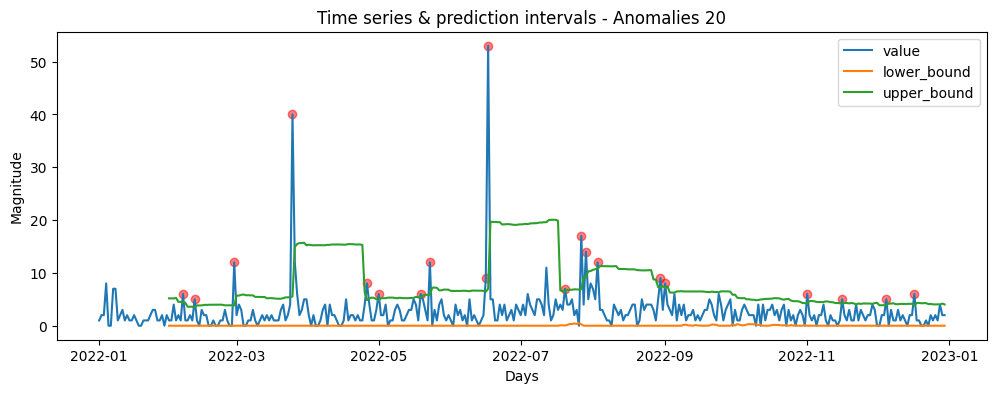

In [7]:
from alerts import plot

plot.plot(mean_ts, show_anomalies=True)

---

## Collective Outliers

In [8]:
from alerts.anomaly import AnomalyDetector
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

dates = df_time_series.date.values
values = df_time_series.value.values
ts = TimeSeries(dates, values)
mean_ts = AnomalyMeanTS(ts)
detector = AnomalyDetector()
groups = detector.detect_alerts_groups(mean_ts)

groups

[[Event(), Event()],
 [Event()],
 [Event()],
 [Event(), Event()],
 [Event(), Event()],
 [Event(), Event()],
 [Event()],
 [Event(), Event(), Event()],
 [Event(), Event()],
 [Event()],
 [Event()],
 [Event()],
 [Event()]]

In [9]:
for i, group in enumerate(groups, start=1):
    print(f"Group: {i}")
    print(10 * "***")
    for event in group:
        print(event.date, event.value)

Group: 1
******************************
2022-02-06T00:00:00.000000000 6
2022-02-11T00:00:00.000000000 5
Group: 2
******************************
2022-02-28T00:00:00.000000000 12
Group: 3
******************************
2022-03-25T00:00:00.000000000 40
Group: 4
******************************
2022-04-26T00:00:00.000000000 8
2022-05-01T00:00:00.000000000 6
Group: 5
******************************
2022-05-19T00:00:00.000000000 6
2022-05-23T00:00:00.000000000 12
Group: 6
******************************
2022-06-16T00:00:00.000000000 9
2022-06-17T00:00:00.000000000 53
Group: 7
******************************
2022-07-20T00:00:00.000000000 7
Group: 8
******************************
2022-07-27T00:00:00.000000000 17
2022-07-29T00:00:00.000000000 14
2022-08-03T00:00:00.000000000 12
Group: 9
******************************
2022-08-30T00:00:00.000000000 9
2022-09-01T00:00:00.000000000 8
Group: 10
******************************
2022-11-01T00:00:00.000000000 6
Group: 11
******************************
2022-11

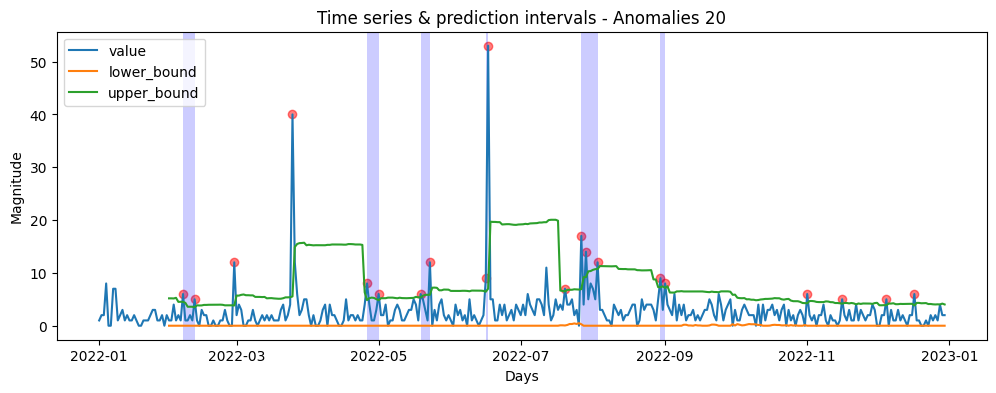

In [10]:
from alerts import plot
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

dates = df_time_series.date.values
values = df_time_series.value.values
ts = TimeSeries(dates, values)
mean_ts = AnomalyMeanTS(ts)

plot.plot_groups(mean_ts, show_anomalies=True)

---

## Segmentation

In [11]:
data.head(1)

,Unnamed: 0,id,text,created_at,lang,source,name,screen_name,bio,us_created_at,...,country_code,locality,region,sub_region,coordinates,date,gender_pred,gender,text_pp,sentiment
0,0,1521032726001901570,@UhKBMxEiE3vRxJa الله وكيلك صابهم اسهال,2022-05-02T07:43:55+00:00,ar,twitter,al Mh,@mh89al89,أثق بي جداً انا صلب\nبما يكفي للتجاوز دائماً ..,2021-11-09T02:32:56+00:00,...,IQ,NaN,NaN,NaN,"33.0, 44.0",2022-05-02,1,woman,الله وكيلك صابهم اسهال,negative


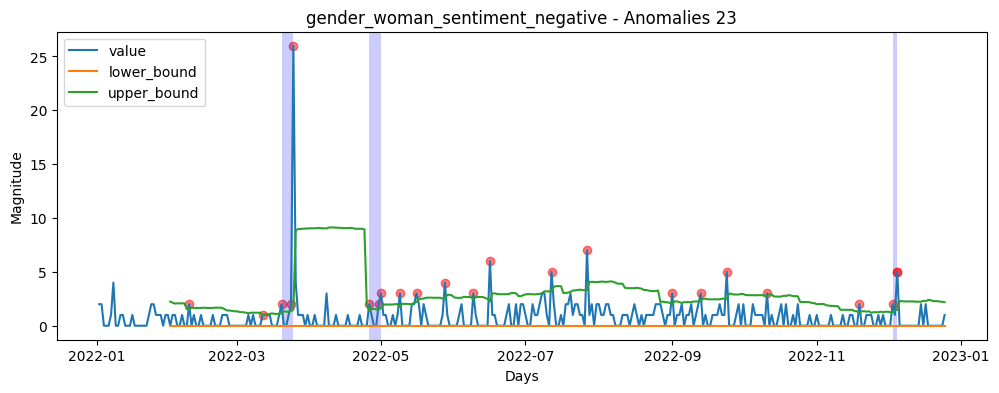

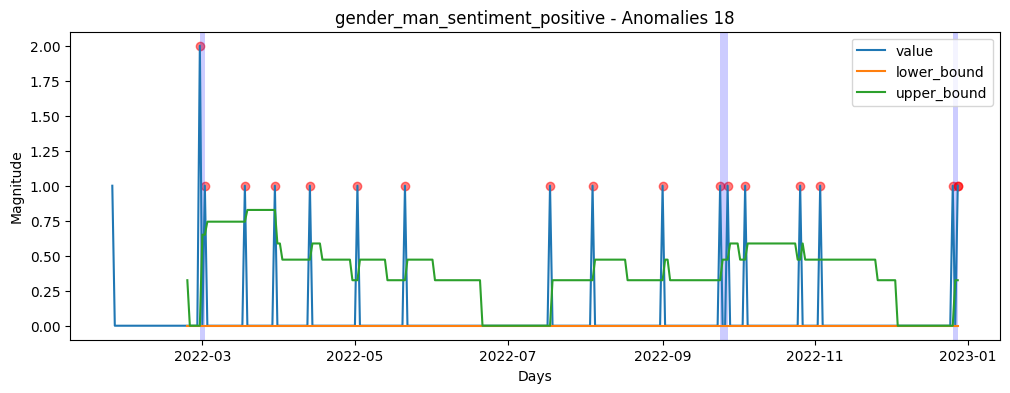

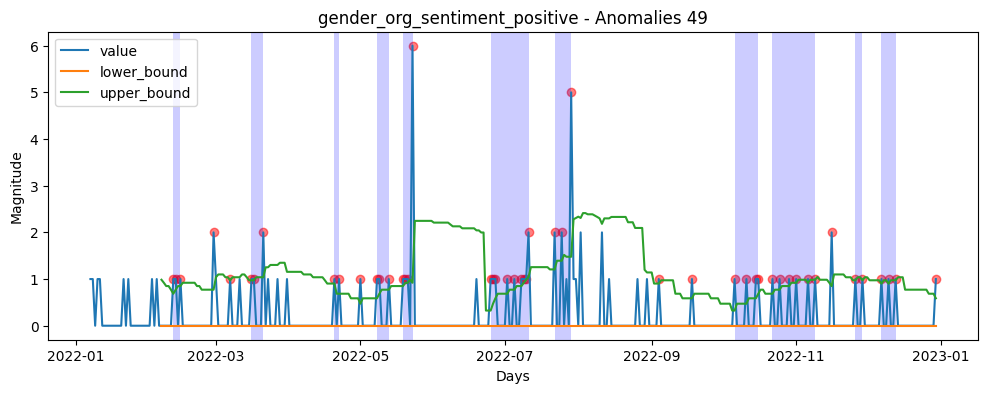

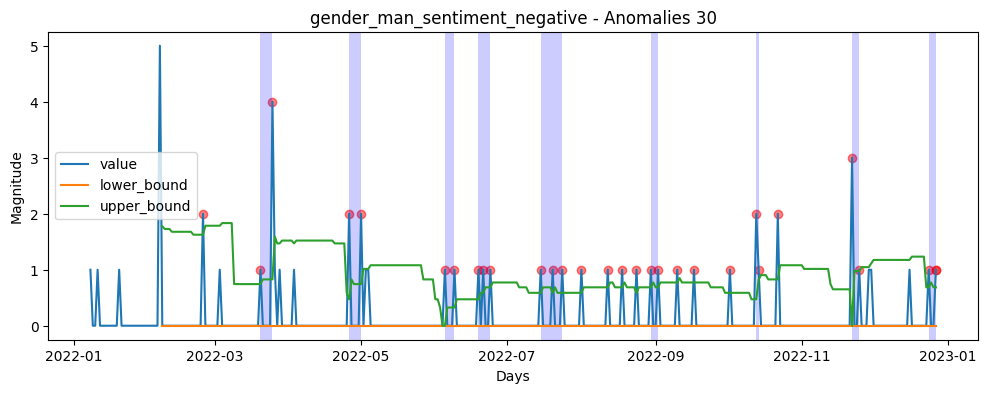

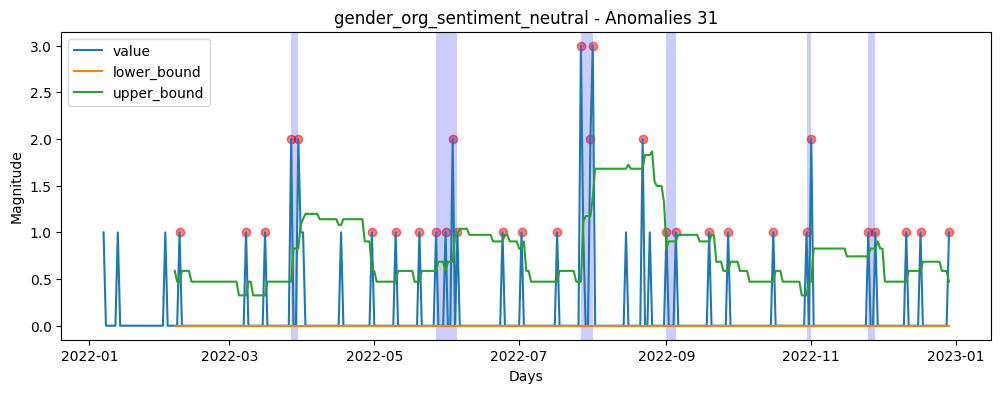

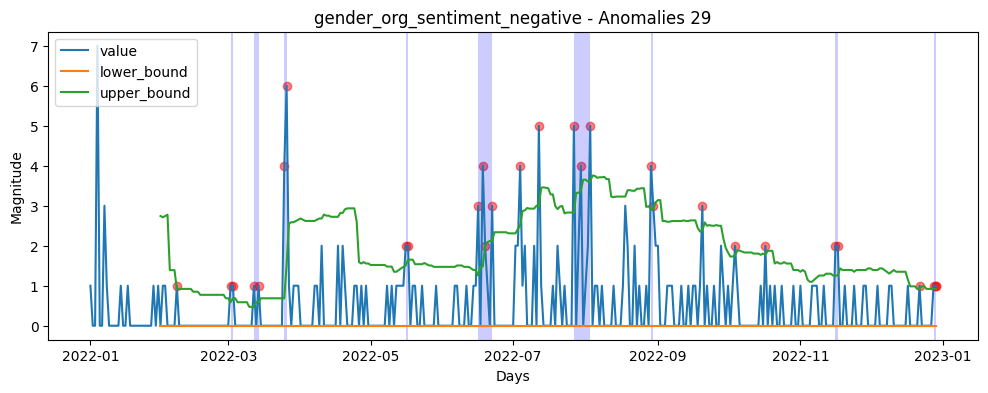

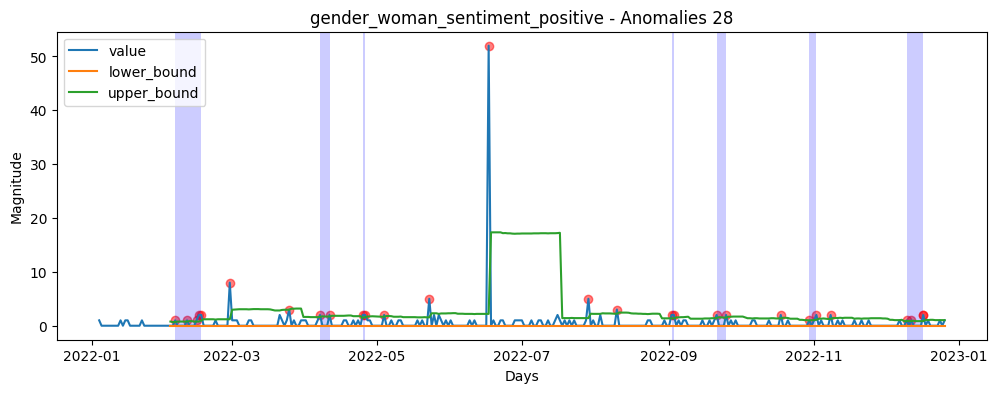

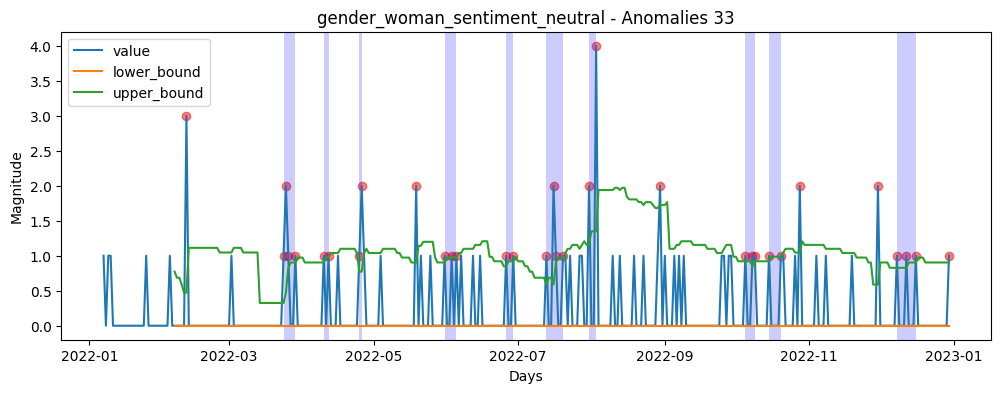

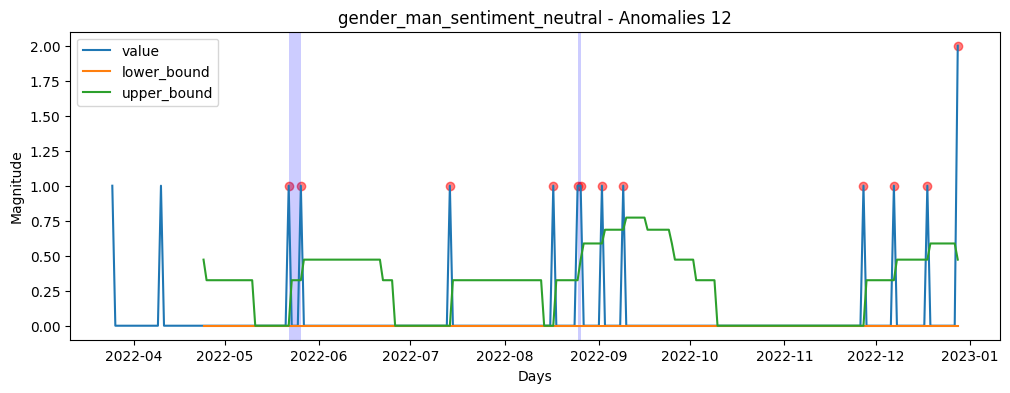

In [12]:
from alerts.utils import dataframe_segmentation
from alerts import plot
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

segmentation_by = ["gender", "sentiment"]
segments = dataframe_segmentation(data, segmentation_by)

for segment_id, segment in segments.items():
    df_time_series = df_to_df_time_series(segment)
    dates = df_time_series.date.values
    values = df_time_series.value.values
    ts = TimeSeries(dates, values)
    mean_ts = AnomalyMeanTS(ts)

    plot.plot_groups(mean_ts, show_anomalies=True, title=segment_id)